[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amingolnari/Learning-Representations-by-Recirculation/blob/main/RecirculationAlgorithm.ipynb)

# **LEARNING REPRESENTATIONS BY RECIRCULATION**

**Geoffrey E. Hinton**

* *Computer Science and Psychology Departments, University of Toronto, 
Toronto M5S lA4, Canada*

**James L. McClelland** 

* *Psychology and Computer Science Departments, Carnegie-Mellon University, 
Pittsburgh, PA 15213*

*-You can read the abstract at the end of this file*

**Import requirements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Union
import numpy.typing as npt
%matplotlib inline

**Update Matplotlib parameters for a better representation**

In [2]:
plt.style.use('seaborn')
plt.rcParams.update({'figure.figsize': [10., 6.], 'font.size': 20, 'axes.titlesize': 20, 'axes.labelsize': 20, 
                     'xtick.labelsize': 20, 'ytick.labelsize': 20, 'legend.fontsize': 20})

**Define a method to add threshold**

In [3]:
def thresh(x, shape, thr = 1):
    """
    :param x:
        -- list or numpy-array
    input array to insert threshold for each nodes
    :param shape:
        -- integer
    The shape of input
    :param thr:
        -- float or int
    Desired value for inserting threshold to each node
    :return:
    """
    return np.append(x, np.asarray([thr]*shape).reshape(shape, 1), axis = 1)

**Define a class for implimenting recirculation algorithm**

In [4]:
class Recirculation:
    def __init__(self, input_shape: int, hidden_units: Union[int, list] = 4, activation: str = 'linear', learning_rate: float = 1., regression_rate: float = .75):
        """
        :param input_shape:
            -- integer (The shape of the input)
        The input shape should be 1D, so you have to pass the input_shape to the class as an integer.
        :param hidden_units:
            -- integer, list or (1D) numpy-array. (The number of hidden units and layers)
        This parameter specifies the number of layers and number of neurons in each layer. You will have just one layer with an
        N-number nodes if you set it as an integer N. Otherwise, You will have a model with the number of layers equal to the length
        of hidden_units, where each element represent the number of neurons in that layer if you set it as a list or an numpy-array.
        default: 4
        :param activation:
            -- string (The activation function)
        This parameter set an activation function to the layers. You have to pass it to the class as a string.
        possible functions you can choose: {'linear', 'relu', 'sigmoid', 'tanh'}.
        default: linear
        :param learning_rate:
            -- float (The learning rate)
        You can set a learning rate by passing this parameter to the class. This parameter can be any but chose a float value.
        default: 1.0
        :param regression_rate:
            -- float (The regression rate)
        You can set a regression rate by passing this parameter to the class. This parameter can be any but chose a float value.
        The paper mentioned it with a value of 0.75.
        default: 0.75
        :return:
            -- Nothing! :-)
        """
        list_of_activation_functions = ['sigmoid', 'relu', 'tanh', 'linear']
        if activation not in list_of_activation_functions:
            raise ValueError(f'You have to choose one of the following activation functions:\n{list_of_activation_functions}\nYou are trying to pass the parameter {activation}')
        self.lr_ = learning_rate  # Set learning rate.
        self.reg_ = regression_rate  # Set regression rate.

        # Modifying hidden units shape by inserting output shape precisely as same as the input shape.
        if type(hidden_units) == int:
            hidden_units = np.append(np.asarray([hidden_units]), input_shape)
        elif type(hidden_units) == list:
            hidden_units.append(input_shape)
        elif type(hidden_units).__name__ == 'ndarray':
            hidden_units = np.append(hidden_units, input_shape)
        else:
            raise ValueError(f'You have to set the hidden_units parameter as type of list or integer. The type of parameter you are trying to pass is {type(hidden_units)}')
        self.nh_ = np.asarray(hidden_units)

        # Weight random initialization using a uniform distribution with values between -.5-.5.
        self.w_ = [np.random.uniform(-.5, .5, (input_shape + 1, hidden_units[0]))]
        for n in range(int(len(hidden_units) - 1)):
            self.w_.append(np.random.uniform(-.5, .5, (hidden_units[n] + 1, hidden_units[n + 1])))

        # Set input shape.
        self.shape_ = input_shape

        # Save mean squared error.
        self.err = []

        if activation == 'sigmoid':
            self.acf_ = lambda x: 1 / (1 + np.exp(-x))  # Sigmoid output values are between 0-1.
        elif activation == 'relu':
            self.acf_ = lambda x: x * (x > 0)  # ReLU activation function ignores negative values you can use max(0, x).
        elif activation == 'tanh':
            self.acf_ = lambda x: np.tanh(x)  # Tanh output values are in the range -1 to 1.
        elif activation == 'linear':
            self.acf_ = lambda x: x  # Linear output values are exactly as same as the input.
        self.acfn_ = activation

    def fit(self, x_data: Union[list, npt.NDArray], epochs: int = 200):
        """
        :param x_data:
            -- list or (1D) numpy-array (The training data)
        Input training data. You can pass the data as a list or 2D numpy-array to the class by setting this parameter.
        :param epochs:
            -- integer (The number of epochs for training phase)
        The number of epoch for training phase.
        :return:
            -- list (Training reconstruction error history)
        This function returns an array of mean squared errors per epoch.
        """
        if len(list(x_data.shape)) > 2:
            raise ValueError(f'The input data should be a 2D array such as the following data:\n{np.eye(2)}\nYou are trying to pass an input data with a shape of:\n{x_data.shape}')
        if epochs < 1:
            raise ValueError(f'Please set the epochs as a positive integer greater than 1. You are trying to pass a parameter {epochs}!')
        for _ in tqdm(range(epochs)):
            # Computing the output of the layers at the first state.
            temp_data = [x_data]
            for n in range(len(self.nh_) - 1):
                temp_data.append(self.acf_(thresh(temp_data[n], self.shape_) @ self.w_[n]))
            # Approximating the gradient descent at the second state.
            for n in range(len(self.nh_)):
                temp_data.append((self.reg_ * temp_data[n]) + ((1 - self.reg_) * self.acf_(thresh(temp_data[n + len(self.nh_) - 1], self.shape_) @ self.w_[n - 1])))
            # Update weights based on approximated GD.
            for n in range(len(self.nh_)):
                self.w_[n - 1] += self.lr_ * thresh(temp_data[n + len(self.nh_) - 1], self.shape_).T @ (temp_data[n] - temp_data[n + len(self.nh_)])
            # Computing mean squared error. (The difference between the original and the reconstructed visible vector)
            self.err.append(np.sum(((temp_data[len(self.nh_)] - temp_data[0]) ** 2) / 2))
            del temp_data
        return self.err

    # This function returns layer weights based on the layer index.
    def get_layer_weights(self, layer_index: int = -1):
        """
        :param layer_index:
            -- integer
        This parameter gets the index of the layer to returns the weights of layer layer_index, so it should be an integer.
        If you are going to get the weights of layer n, set this parameter to n.
        :return:
            -- list
        The weights of layer layer_index.
        """
        if layer_index > len(self.w_)-1:
            raise ValueError(f'The index you have chosen is out of length. Maximum possible value for layer_index is {len(self.w_)-1}, you set layer_index to {layer_index}')
        return self.w_[layer_index][:-1]

    # This function returns layer output based on the layer index
    def get_layer_output(self, x_data: Union[list, npt.NDArray], layer_index: int = -1, get_reconstruction_error: bool = False):
        """
        :param x_data:
            -- list or (1D) numpy-array (The training data)
        Input training data. You can pass the data as a list or 2D numpy-array to the class by setting this parameter.
        :param layer_index:
            -- integer
        This parameter gets the index of the layer to returns the output of layer layer_index, so it should be an integer.
        If you are going to get the weights of layer n, set this parameter to n.
        :param get_reconstruction_error:
            -- boolean
        It true, then you can get reconstruction error of layer layer_index.
        :return:
            -- layer output (and reconstruction error)
        """
        if len(list(x_data.shape)) > 2:
            raise ValueError(f'The input data should be a 2D array such as the following data:\n{np.eye(2)}\nYou are trying to pass an input data with a shape of:\n{x_data.shape}')
        if layer_index > len(self.nh_):
            raise ValueError(f'The index you have chosen is out of length. Maximum possible value for layer_index is {len(self.nh_)}, you set layer_index to {layer_index}')
        temp_data = [x_data]
        for n in range(len(self.nh_)):
            temp_data.append(self.acf_(thresh(temp_data[n], self.shape_) @ self.w_[n]))
        if get_reconstruction_error:
            return temp_data[layer_index], temp_data[-1]
        else:
            return temp_data[layer_index]

    # This function returns model output
    def predict(self, test_data: Union[list, npt.NDArray], true_val: bool = True):
        """
        :param test_data:
            -- list or numpy-array (The testing data)
        Input testing data. You can pass the data as a list or 2D numpy-array to the class by setting this parameter.
        Therefore you can get the output of the model according to the input of test_data
        :param true_val:
            -- boolean
        If true, returns the actual output without decoding. Otherwise, returns decoded output using argmax
        :return:
            -- list
        Calling this function returns the prediction of the model based on the test_data
        """
        if len(list(test_data.shape)) > 2:
            raise ValueError(f'The input data should be a 2D array such as the following data:\n{np.eye(2)}\nYou are trying to pass an input data with a shape of:\n{test_data.shape}')
        temp_data = [test_data]
        for n in range(len(self.nh_)):  # If you are going to get logical output set true_val = False
            temp_data.append(self.acf_(thresh(temp_data[n], self.shape_) @ self.w_[n]))
        if not true_val:
            return np.eye(self.shape_)[np.argmax(temp_data[-1], axis = 1)]
        else:
            return temp_data[-1]

    # By calling this function you can plot the training error
    def plot_error(self):
        """
        :return:
            -- A graph shows mean squared error during training phase
        """
        x = np.arange(1, len(self.err) + 1, step = 1)
        plt.plot(x, self.err, label = 'MSE', linewidth = 2, color = 'r')
        plt.axhline(y = .1, color = 'b', linestyle = '-.')
        plt.vlines(x = 48, ymin = 0, ymax = self.err[47], color = 'g', linestyle = '-.')
        plt.text(x = 49, y = self.err[47] * 1.01, s = f'Epoch: 48 - MSE: {self.err[47]:.4f}!')
        plt.text(x = 10, y = .101, s = f'MSE: 0.1')
        plt.title(f'Training History (Activation: {self.acfn_})')
        plt.ylabel('Mean Squared Error')
        plt.xlabel('Epoch')
        plt.xticks(x[::9])
        plt.xlim([0, 101])
        plt.ylim([np.min(self.err) * .8, np.max(self.err) * 1.01])
        plt.legend()
        plt.show()

**Set inputs as mentioned in the paper:**
*   "...The visible vectors were **1000**, **0100**, **0010** and **0001**..."



In [5]:
train_data = np.eye(4)
train_data

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

**Set Parameters of training according to page 363**

Somewhere on page 363 have written:
*   ... the 2 hidden units ...
*   ... $\lambda$ of 0.75 ... (Regression rate for estimating gradient descent state)
*   ... $\epsilon$ of 20 ... (Learning rate for training state. *Why the learning rate should be chosen that much high!!!*) 
* ... $\frac{1}{1+e^{-x_{i}}}$ ... (For hidden units we use the logistic 
function)

In [6]:
params = {
    'input_shape':          train_data.shape[0],
    'hidden_units':         2,
    'activation_function':  'sigmoid',
    'learning_rate':        1., 
    'regression_rate':      .75,
    'epochs':               100
}

**Pass arguments to the defined class**

In [7]:
ac = Recirculation(input_shape = params['input_shape'], 
                   hidden_units = params['hidden_units'], 
                   activation = params['activation_function'], 
                   learning_rate = params['learning_rate'], 
                   regression_rate = params['regression_rate'])

**Fit the model**

In [8]:
hist = ac.fit(train_data, epochs = params['epochs'])

100%|██████████| 100/100 [00:00<00:00, 8849.86it/s]


**Graph mean squared error over training**

**-NOTE:** *According to my understanding of the paper, the error reached less than 0.1 at epoch 48, based on page 363!*

*  *...reconstruction error of less than 0.1 on every unit in an **average** of 48 weight updates...*

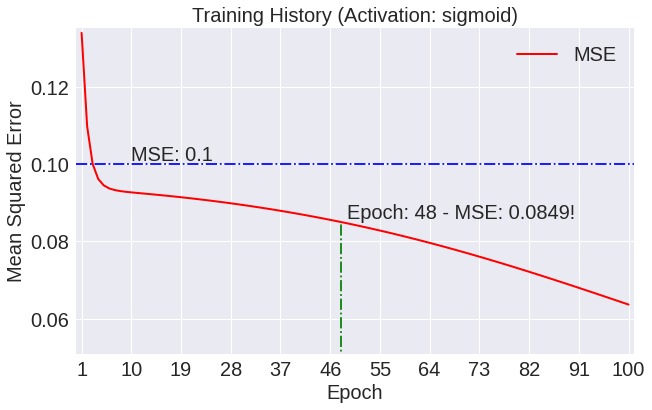

In [9]:
ac.plot_error()

**Get the actual output of the model**

In [10]:
y_pred = ac.predict(test_data = train_data, true_val = True)
y_pred

array([[0.4021731 , 0.13244971, 0.28543807, 0.18463546],
       [0.12879545, 0.39335145, 0.19758682, 0.30485013],
       [0.30517558, 0.23281127, 0.33371881, 0.15591873],
       [0.14024299, 0.26377855, 0.11752223, 0.45697702]])

**Get decoded (argmax) output of the model**

In [11]:
y_pred = ac.predict(test_data = train_data, true_val = False)
y_pred

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

**NOTE:** *Using a different activation function instead of logistic, provides a better answer! (Experimentally)*

# **ABSTRACT**

*We describe a new learning procedure for networks that contain groups of non- linear units arranged in a closed loop. The aim of  the learning  is to discover  codes that allow the activity vectors in a "visible" group to be  represented  by  activity vectors in a "hidden" group. One way to test whether a code is an accurate representation is to try to reconstruct the visible vector from the hidden vector. The difference between the original and the reconstructed visible vectors is called the reconstruction error, and ihe learning procedure aims to minimize this error. The learning procedure has two passes. On the first  pass,  the  original  visible  vector  is passed around the loop, and on the second pass an average of the origirial vector and the reconstructed vector is passed around  the  loop.  The  learning  procedure  changes each weight by an amount proportional to the product of the  "presynaptic"  actiYity and the difference in the post-synaptic activity on the two passes. This procedure is much simpler to implement than methods like back-propagation.  Simulations  in simple networks show that it usually converges rapidly on a good set of codes, and analysis shows that in certain restricted cases it performs gradient descent in  the squared reconstruction error.*

**Paper link**

https://proceedings.neurips.cc/paper/1987/file/35f4a8d465e6e1edc05f3d8ab658c551-Paper.pdf